In [3]:
import os
import networkx as nx
from networkx.algorithms import bipartite
import community as community_louvain
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
sns.set_style('whitegrid')
import pandas as pd
import numpy as np

In [31]:
os.getcwd()

'/home/tduricic/Development/workspace/elliot/notebooks'

In [8]:
filmtrust_ratings_filename = '../data/filmtrust/processed/ratings.tsv'
def create_ratings_bipartite_graph(filename):
    users = set()
    items = set()
    user_items_dict = {}
    edges = []
    with open(filename) as fr:
        for line in fr.readlines():
            tokens = line.split()
            userId = tokens[0]
            itemId = tokens[1]
            # For now we omit the weight
            # rating = float(tokens[2])

            users.add(userId)
            items.add(itemId)
            edges.append((userId, itemId))
            if userId not in user_items_dict:
                user_items_dict[userId] = []
                user_items_dict[userId].append(itemId)
            else:
                user_items_dict[userId].append(itemId)
    B = nx.Graph()
    B.add_nodes_from(users, bipartite=0)
    B.add_nodes_from(items, bipartite=1)
    B.add_edges_from(edges)

    return B, user_items_dict, users, items

In [9]:
B, user_items_dict, users, items = create_ratings_bipartite_graph(filmtrust_ratings_filename)

In [10]:
projected_G = bipartite.projected_graph(B, items)

In [11]:
partition = community_louvain.best_partition(projected_G)

In [7]:
partition

{'8020': 0,
 '15699': 0,
 '4909': 1,
 '6145': 1,
 '4745': 3,
 '1778': 0,
 '3306': 0,
 '1003': 3,
 '3059': 1,
 '6003': 3,
 '16109': 0,
 '5723': 0,
 '10368': 3,
 '9433': 0,
 '15736': 4,
 '10604': 0,
 '15220': 9,
 '5386': 9,
 '4440': 0,
 '14503': 0,
 '15022': 0,
 '7733': 0,
 '11713': 3,
 '6018': 1,
 '7687': 3,
 '8283': 3,
 '10767': 0,
 '2026': 0,
 '12142': 3,
 '11737': 0,
 '6935': 0,
 '14367': 0,
 '6699': 0,
 '6578': 6,
 '15598': 7,
 '7313': 7,
 '5650': 0,
 '13621': 7,
 '3816': 3,
 '538': 3,
 '4525': 7,
 '5749': 3,
 '5888': 3,
 '3339': 3,
 '7127': 0,
 '7368': 6,
 '2414': 6,
 '13434': 0,
 '10160': 3,
 '14164': 7,
 '3363': 0,
 '6732': 0,
 '2095': 0,
 '5920': 4,
 '12920': 0,
 '14572': 5,
 '15599': 0,
 '8325': 9,
 '5201': 10,
 '8906': 9,
 '14548': 11,
 '11998': 0,
 '13659': 0,
 '12085': 0,
 '11262': 3,
 '3249': 0,
 '15408': 6,
 '7150': 6,
 '5490': 0,
 '10192': 0,
 '1907': 0,
 '6264': 3,
 '7757': 0,
 '1740': 0,
 '8434': 6,
 '9519': 1,
 '11100': 11,
 '4742': 1,
 '13658': 0,
 '15730': 3,
 '3055'

In [12]:
community_lists = {}
for key in partition:
    if partition[key] not in community_lists:
        community_lists[partition[key]] = []
        community_lists[partition[key]].append(key)
    else:
        community_lists[partition[key]].append(key)

In [13]:
len(community_lists)

5

In [14]:
community_sizes = {}
for key in community_lists:
    community_sizes[key] = len(community_lists[key])

In [15]:
community_sizes

{4: 534, 1: 602, 3: 550, 2: 184, 0: 201}

In [16]:
community_sizes_list = list(community_sizes.values())

In [17]:
community_sizes_list.sort(reverse=True)

In [18]:
community_sizes_list

[602, 550, 534, 201, 184]

In [19]:
community_ids = range(1, len(community_sizes)+1)

In [20]:
df = pd.DataFrame({"Community id":community_ids, "Community size":community_sizes_list})

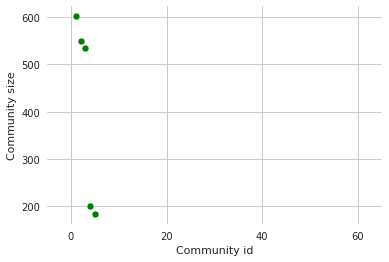

In [21]:
sns.set_style('whitegrid')
ax = sns.scatterplot(data=df, x='Community id', y='Community size', color='green')

ax.set(xlim=(-5, 65))
# ax.set(ylim=(-0.1, 3.2))
# ax.set(xticklabels=['',1,'',10,'',100,'',1000,'',10000])
# ax.set(yticklabels=['',1,'',10,'',100,'',1000])
sns.set(font_scale = 1.5)

# plt.savefig('../plots/community_size_distribution1.pdf', bbox_inches='tight')
plt.show()

In [22]:
user_communities_interactions_dict = {}
for userId in user_items_dict:
    if userId not in user_communities_interactions_dict:
        user_communities_interactions_dict[userId] = [0] * len(community_lists)
    for itemId in user_items_dict[userId]:
        user_communities_interactions_dict[userId][partition[itemId]] += 1

In [23]:
x = np.array(user_communities_interactions_dict['1'])
x

array([ 0,  0,  0,  0, 12])

In [24]:
np.sum(x/np.max(x))/x.shape[0]

0.2

In [25]:
user_diversities = {}
for userId in user_communities_interactions_dict:
    user_community_vector = np.array(user_communities_interactions_dict[userId])
    user_diversities[userId] = np.sum(user_community_vector/np.max(user_community_vector))/user_community_vector.shape[0]

In [26]:
x = np.array(user_diversities.values())

In [27]:
user_diversities_filtered = {}
for userId in user_diversities:
    if user_diversities[userId] > 0 and user_diversities[userId] <=1:
        user_diversities_filtered[userId] = user_diversities[userId]

In [28]:
user_diversities_df = pd.DataFrame({'userId':list(user_diversities_filtered.keys()), 'diversity':list(user_diversities_filtered.values())})

In [29]:
user_diversities_df

,userId,diversity
0,1,0.200000
1,2,0.200000
2,3,0.465060
3,4,0.200000
4,5,0.200000
...,...,...
1503,1504,0.255556
1504,1505,0.266667
1505,1506,0.200000
1506,1507,0.200000


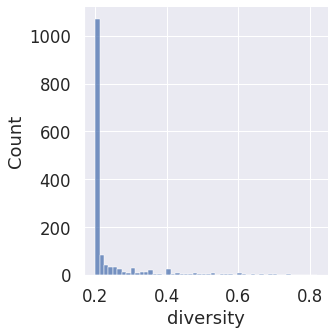

In [30]:
sns.displot(user_diversities_df, x="diversity", bins=50)

In [37]:
source_diversities = []
target_diversities = []
filmtrust_social_filename = '../data/filmtrust/processed/social_connections.tsv'
with open(filmtrust_social_filename) as fr:
        for line in fr.readlines():
            tokens = line.split()
            source_user = tokens[0]
            target_user = tokens[1]
            if source_user in user_diversities_filtered and target_user in user_diversities_filtered:
                source_diversities.append(user_diversities_filtered[source_user])
                target_diversities.append(user_diversities_filtered[target_user])

In [38]:
source_diversities = np.array(source_diversities)
target_diversities = np.array(target_diversities)

In [39]:
from scipy.stats.stats import pearsonr
pearsonr(source_diversities, target_diversities)[0]

0.07491768392125187